### Notebook Information

#### In this notebook we are running the LeNet model on CIFAR 10 dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision

numEpochs = 10
learningRate = 0.001
numClasses = 10

In [2]:
if not torch.cuda.is_available():
  device = torch.device('cpu')
else:
  device = torch.device('cuda')

In [3]:
# Get the training and testing set
trainingset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

testingset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
# Create the dataset loaders
trainloader = torch.utils.data.DataLoader(trainingset, batch_size=128, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testingset, batch_size=128, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Create a LeNet Neural network
class LeNet5(nn.Module):
    def __init__(self, numClasses):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, numClasses)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out


In [5]:
class NeuralNetwork:
  def __init__(self, trainloader, testloader, learning_rate):
    self.model = LeNet5(numClasses).to(device)
    self.cost = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    self.trainloader=trainloader
    self.testloader=testloader
    self.val_losses = []
    self.train_losses = []
    self.val_acc = []
    self.train_acc = []

  def lossplot(self):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(self.val_losses,label="val")
    plt.plot(self.train_losses,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def accplot(self):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(self.val_acc,label="val")
    plt.plot(self.train_acc,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def trainCuda(self,epoch):
    correct = 0
    total = 0
    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.cost(outputs, labels)
        loss.backward()
        self.optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        runningLoss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i+1) % 20 == 0: 
            print("Epoch:{}, Iteration:{}, Loss:{:.3f}".format(epoch + 1, i + 1, runningLoss / (i+1)))
    return (runningLoss/len(trainloader), (100*correct / total))

  def testCuda(self):
    correct = 0
    total = 0
    runningLoss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = self.model(inputs)
            loss=self.cost(outputs,labels)
            runningLoss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy: %d %%' % (100 * correct / total))
    return (runningLoss/len(testloader), (100*correct / total))

  def fit(self):
    for epoch in range(numEpochs):
      running_loss_train, running_train_acc = self.trainCuda(epoch)
      running_loss_test, running_test_acc = self.testCuda()
      self.train_losses.append(running_loss_train)
      self.val_losses.append(running_loss_test)
      self.train_acc.append(running_train_acc)
      self.val_acc.append(running_test_acc)

In [6]:
for i, data in enumerate(trainloader, 0):
  if(i>5):
    break
  print(data[1])

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])
tensor([5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6,
        7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4,
        1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0,
        6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0,
        6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4,
        6, 6, 1, 3, 8, 3, 4, 1])
tensor([7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0,
        8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9

In [7]:
neuralNet = NeuralNetwork(trainloader, testloader, learningRate)

In [8]:
# Fit the LeNet5 Neural Network
neuralNet.fit()

Epoch:1, Iteration:20, Loss:2.154
Epoch:1, Iteration:40, Loss:1.998
Epoch:1, Iteration:60, Loss:1.903
Epoch:1, Iteration:80, Loss:1.840
Epoch:1, Iteration:100, Loss:1.790
Epoch:1, Iteration:120, Loss:1.751
Epoch:1, Iteration:140, Loss:1.717
Epoch:1, Iteration:160, Loss:1.687
Epoch:1, Iteration:180, Loss:1.659
Epoch:1, Iteration:200, Loss:1.631
Epoch:1, Iteration:220, Loss:1.610
Epoch:1, Iteration:240, Loss:1.591
Epoch:1, Iteration:260, Loss:1.579
Epoch:1, Iteration:280, Loss:1.567
Epoch:1, Iteration:300, Loss:1.556
Epoch:1, Iteration:320, Loss:1.544
Epoch:1, Iteration:340, Loss:1.532
Epoch:1, Iteration:360, Loss:1.522
Epoch:1, Iteration:380, Loss:1.514
Test Accuracy: 51 %
Epoch:2, Iteration:20, Loss:1.291
Epoch:2, Iteration:40, Loss:1.303
Epoch:2, Iteration:60, Loss:1.297
Epoch:2, Iteration:80, Loss:1.291
Epoch:2, Iteration:100, Loss:1.293
Epoch:2, Iteration:120, Loss:1.295
Epoch:2, Iteration:140, Loss:1.289
Epoch:2, Iteration:160, Loss:1.285
Epoch:2, Iteration:180, Loss:1.281
Epoch:2,

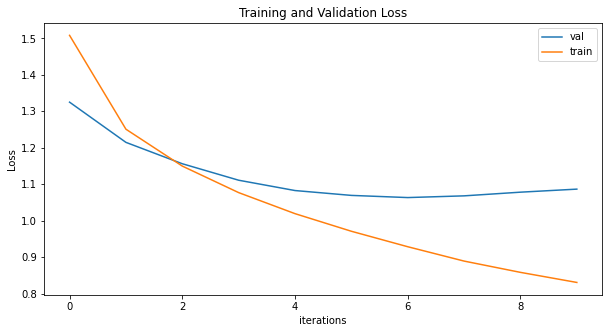

In [9]:
neuralNet.lossplot()

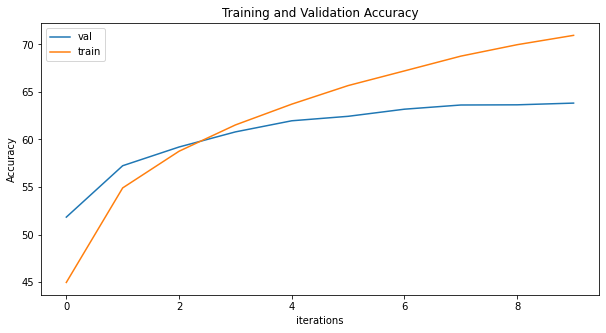

In [10]:
neuralNet.accplot()